In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [3]:
train_data = pd.read_csv("../Data_processing/Data_Splitting/2005_2024/All_prefecture_Housing_training_data.csv")
dev_data = pd.read_csv("../Data_processing/Data_Splitting/2005_2024/All_prefecture_Housing_dev_data.csv")
cols_to_exclude = ["Type","Prefecture","Location"]
train_data.drop(columns=cols_to_exclude, inplace=True)
dev_data.drop(columns=cols_to_exclude, inplace=True)
train_data_filtered = train_data[train_data["TotalTransactionValue"] >= 1e5]
dev_data_filtered = dev_data[dev_data["TotalTransactionValue"] >= 1e5]

In [4]:

# Filter out any rows with zero or negative values (log undefined)
train_data_filtered = train_data_filtered[train_data_filtered["TotalTransactionValue"] > 0]

# Take log10 of the transaction values
log_values = np.log10(train_data_filtered["TotalTransactionValue"])

# Define number of bins in log space
n_bins = 40

# Bin in log space
train_data_filtered["log_bin"] = pd.cut(log_values, bins=n_bins)

# Count number of samples per bin
bin_counts = train_data_filtered["log_bin"].value_counts().sort_index()

# Target samples per bin — use max, mean, or a fixed number
target_count = int(bin_counts.max())

# Oversample each bin to match the target count
balanced_parts = []
for bin_range, count in bin_counts.items():
    bin_data = train_data_filtered[train_data_filtered["log_bin"] == bin_range]
    if count == 0:
        continue
    multiplier = int(np.ceil(target_count / count))
    oversampled = pd.concat([bin_data] * multiplier, ignore_index=True)
    balanced_parts.append(oversampled.sample(n=target_count, replace=True))

# Combine and shuffle
train_data_uniform_log = pd.concat(balanced_parts, ignore_index=True)
train_data_uniform_log = train_data_uniform_log.sample(frac=1, random_state=42).reset_index(drop=True)

# Drop helper column
train_data_uniform_log.drop(columns=["log_bin"], inplace=True)



In [5]:
train_data_uniform_log['TotalTransactionValue'].to_csv('total_transaction_value_uniform_log.txt', index=False, header=False)


In [96]:
#print(train_data_balanced.describe())
print(dev_data_filtered.columns)

Index(['TotalTransactionValue', 'Area', 'Frontage', 'TotalFloorArea',
       'ConstructionYear', 'BuildingCoverageRatio', 'FloorAreaRatio',
       'Quarter', 'Year', 'RegionCommercialArea', 'RegionIndustrialArea',
       'RegionPotentialResidentialArea', 'RegionResidentialArea',
       'MunicipalityCategory', 'Region_Chubu', 'AverageTimeToStation',
       'FloorAreaGreaterFLag', 'BeforeWarFlag', 'frontage_greater_than_50',
       'AreaGreaterFlag', 'Region_Chugoku', 'Region_Hokkaido', 'Region_Kansai',
       'Region_Kanto', 'Region_Kyushu', 'Region_Shikoku', 'Region_Tohoku'],
      dtype='object')


In [15]:
train_target_uniform_log = train_data_uniform_log['TotalTransactionValue'].values.astype(np.float32)
dev_target = dev_data_filtered['TotalTransactionValue'].values.astype(np.float32)


#train_target = np.minimum(train_target, cap)
#dev_target = np.minimum(dev_target, cap)
train_target_log = np.log10(train_target_uniform_log + 1)
dev_target_log = np.log10(dev_target + 1)

# Extract features (without the target) as before
train_features_filtered = train_data_uniform_log.drop('TotalTransactionValue', axis=1).values.astype(np.float32)
dev_features_filtered = dev_data_filtered.drop('TotalTransactionValue', axis=1).values.astype(np.float32)


normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train_features_filtered)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(train_features_filtered.shape[1],)),
    normalizer,
    tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0005)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, kernel_regularizer=regularizers.l2(0.0005)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.0005)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])


# Learning rate schedule for exponential decay.
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005, 
    decay_steps=300000, #Approximately every 10 epochs
    decay_rate=0.99, 
    staircase=True
)

# Compile the model with Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='mae')

# Model summary
model.summary()

/home/linuxbrew/.linuxbrew/Cellar/python@3.10/3.10.8/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ (None, 26)             │            53 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │        13,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,230 (696.21 KB)

 Trainable params: 178,177 (696.00 KB)

 Non-trainable params: 53 (216.00 B)

In [24]:
class PlotPredictionsCallback_log(tf.keras.callbacks.Callback):
    def __init__(self, dev_features, dev_target_log, out_dir="epoch_plots_log_data_mod"):
        super().__init__()
        self.dev_features = dev_features
        self.dev_target_log = dev_target_log
        self.out_dir = out_dir
        os.makedirs(out_dir, exist_ok=True)
        self.feature_names = [
            'Area', 'Frontage', 'TotalFloorArea', 'ConstructionYear', 'BuildingCoverageRatio',
            'FloorAreaRatio', 'Quarter', 'Year', 'RegionCommercialArea', 'RegionIndustrialArea',
            'RegionPotentialResidentialArea', 'RegionResidentialArea', 'MunicipalityCategory',
            'Region_Chubu', 'AverageTimeToStation', 'FloorAreaGreaterFLag', 'BeforeWarFlag',
            'frontage_greater_than_50', 'AreaGreaterFlag', 'Region_Chugoku', 'Region_Hokkaido',
            'Region_Kansai', 'Region_Kanto', 'Region_Kyushu', 'Region_Shikoku', 'Region_Tohoku'
        ]

    def on_epoch_end(self, epoch, logs=None):
        preds_log = self.model.predict(self.dev_features).flatten()
        preds = np.power(10, preds_log) - 1
        true_vals = np.power(10, self.dev_target_log) - 1

        # Stack features + true + pred
        output = np.column_stack((self.dev_features, true_vals, preds))

        # Construct header with a leading '#'
        header = "#" + "\t".join(self.feature_names + ["true", "pred"])

        # Save to file
        np.savetxt(
            f"{self.out_dir}/epoch_{epoch+1:03d}.txt",
            output,
            header=header,
            fmt="%.6f",
            delimiter="\t",
            comments=''
        )

        # Plotting
        plt.figure(figsize=(6, 5))
        plt.scatter(true_vals, preds, alpha=0.3)
        plt.plot([true_vals.min(), true_vals.max()], [true_vals.min(), true_vals.max()], 'r--')
        plt.xlabel("True Price")
        plt.ylabel("Predicted Price")
        plt.title(f"True vs Predicted (Epoch {epoch+1})")
        plt.grid(True)
        plt.xscale("log")
        plt.yscale("log")
        plt.tight_layout()
        plt.savefig(f"{self.out_dir}/epoch_{epoch+1:03d}.png")
        plt.close()


In [16]:
#train_features_filtered = train_data_filtered.drop('TradePrice', axis=1).astype('float32').values
#dev_features_filtered = dev_data_filtered.drop('TradePrice', axis=1).astype('float32').values
plot_callback = PlotPredictionsCallback_log(dev_features_filtered, dev_target_log)
history = model.fit(
    train_features_filtered, train_target_log, 
    epochs=50, 
    batch_size=256, 
    validation_data=(dev_features_filtered, dev_target_log),
    callbacks=[plot_callback]
     )

# Get training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/50
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
33868/33868 ━━━━━━━━━━━━━━━━━━━━ 405s 12ms/step - loss: 0.4356 - val_loss: 0.2892
Epoch 2/50
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
33868/33868 ━━━━━━━━━━━━━━━━━━━━ 409s 12ms/step - loss: 0.3488 - val_loss: 0.3030
Epoch 3/50
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
33868/33868 ━━━━━━━━━━━━━━━━━━━━ 414s 12ms/step - loss: 0.3480 - val_loss: 0.2933
Epoch 4/50
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 3s 676us/step
33868/33868 ━━━━━━━━━━━━━━━━━━━━ 338s 10ms/step - loss: 0.3479 - val_loss: 0.3057
Epoch 5/50
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 3s 764us/step
33868/33868 ━━━━━━━━━━━━━━━━━━━━ 290s 9ms/step - loss: 0.3480 - val_loss: 0.3086
Epoch 6/50
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 3s 757us/step
33868/33868 ━━━━━━━━━━━━━━━━━━━━ 291s 9ms/step - loss: 0.3478 - val_loss: 0.2843
Epoch 7/50
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 3s 745us/step
33868/33868 ━━━━━━━━━━━━━━━━━━━━ 289s 9ms/step - loss: 0.3478 - val_loss: 0.2878
Epoch 8/50
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 3

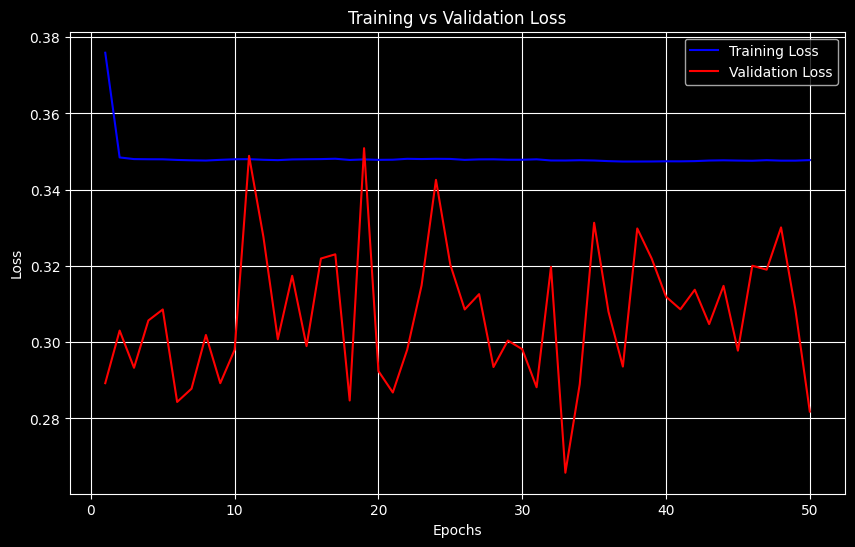

In [17]:
plt.figure(figsize=(10, 6))
plt.style.use('dark_background')
plt.plot(range(1, 51), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, 51), val_loss, label='Validation Loss', color='red')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0,100)
#plt.xscale("log")
#plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Remove Tokyo rows from training and development data
train_data = pd.read_csv("../Data_processing/Data_Splitting/2005_2024/All_prefecture_Housing_training_data.csv")
dev_data = pd.read_csv("../Data_processing/Data_Splitting/2005_2024/All_prefecture_Housing_dev_data.csv")
train_data = train_data[train_data['Prefecture'] != 'Tokyo'].reset_index(drop=True)
dev_data = dev_data[dev_data['Prefecture'] != 'Tokyo'].reset_index(drop=True)
dev_data = dev_data[dev_data["TotalTransactionValue"] >= 1e5]
#dev_data.to_csv("fortopcat.csv")
cols_to_exclude = ["Type","Prefecture","Location"]
train_data.drop(columns=cols_to_exclude, inplace=True)
dev_data.drop(columns=cols_to_exclude, inplace=True)
train_data_filtered = train_data[train_data["TotalTransactionValue"] >= 1e5]
dev_data_filtered = dev_data[dev_data["TotalTransactionValue"] >= 1e5]



In [19]:

train_target = train_data['TotalTransactionValue'].values.astype(np.float32)
dev_target = dev_data_filtered['TotalTransactionValue'].values.astype(np.float32)


#train_target = np.minimum(train_target, cap)
#dev_target = np.minimum(dev_target, cap)
train_target_log = np.log10(train_target + 1)
dev_target_log = np.log10(dev_target + 1)

# Extract features (without the target) as before
train_features_filtered = train_data.drop('TotalTransactionValue', axis=1).values.astype(np.float32)
dev_features_filtered = dev_data_filtered.drop('TotalTransactionValue', axis=1).values.astype(np.float32)


normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train_features_filtered)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(train_features_filtered.shape[1],)),
    normalizer,
    tf.keras.layers.Dense(512),
    tf.keras.layers.ReLU(),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256),
    tf.keras.layers.ReLU(),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128),
    tf.keras.layers.ReLU(),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])


# Learning rate schedule for exponential decay.
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005, 
    decay_steps=300000, #Approximately every 10 epochs
    decay_rate=0.99, 
    staircase=True
)

# Compile the model with Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='mae')

# Model summary
model.summary()

/home/linuxbrew/.linuxbrew/Cellar/python@3.10/3.10.8/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (None, 26)             │            53 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │        13,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,230 (696.21 KB)

 Trainable params: 178,177 (696.00 KB)

 Non-trainable params: 53 (216.00 B)

In [26]:
plot_callback = PlotPredictionsCallback_log(dev_features_filtered, dev_target_log)
history = model.fit(
    train_features_filtered, train_target_log, 
    epochs=20, 
    batch_size=256, 
    validation_data=(dev_features_filtered, dev_target_log),
    callbacks=[plot_callback]
     )

# Get training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/20
3741/3741 ━━━━━━━━━━━━━━━━━━━━ 3s 817us/step
3745/3745 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 0.3127 - val_loss: 0.1831
Epoch 2/20
3741/3741 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3745/3745 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 0.1862 - val_loss: 0.1743
Epoch 3/20
3741/3741 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3745/3745 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - loss: 0.1779 - val_loss: 0.1688
Epoch 4/20
3741/3741 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3745/3745 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.1723 - val_loss: 0.1745
Epoch 5/20
3741/3741 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3745/3745 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.1685 - val_loss: 0.1618
Epoch 6/20
3741/3741 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3745/3745 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.1655 - val_loss: 0.1610
Epoch 7/20
3741/3741 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3745/3745 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.1645 - val_loss: 0.1666
Epoch 8/20
3741/3741 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3745/3745 ━━━━

In [21]:
# Define thresholds for "low" and "high" value transactions
low_thresh = 5e5
high_thresh = 5e7

# Separate subsets
low_value = train_data_filtered[train_data_filtered["TotalTransactionValue"] < low_thresh]
high_value = train_data_filtered[train_data_filtered["TotalTransactionValue"] > high_thresh]
middle_value = train_data_filtered[
    (train_data_filtered["TotalTransactionValue"] >= low_thresh) &
    (train_data_filtered["TotalTransactionValue"] <= high_thresh)
]

# Duplicate low and high-value data (e.g., 3x low, 2x high)
low_value_oversampled = pd.concat([low_value]*50, ignore_index=True)
high_value_oversampled = pd.concat([high_value]*1, ignore_index=True)

# Combine back with middle values
train_data_balanced = pd.concat([middle_value, low_value_oversampled, high_value_oversampled], ignore_index=True)

In [22]:
train_target_balanced = train_data_balanced['TotalTransactionValue'].values.astype(np.float32)
dev_target = dev_data_filtered['TotalTransactionValue'].values.astype(np.float32)


#train_target = np.minimum(train_target, cap)
#dev_target = np.minimum(dev_target, cap)
train_target_log = np.log10(train_target_balanced + 1)
dev_target_log = np.log10(dev_target + 1)

# Extract features (without the target) as before
train_features_filtered = train_data_balanced.drop('TotalTransactionValue', axis=1).values.astype(np.float32)
dev_features_filtered = dev_data_filtered.drop('TotalTransactionValue', axis=1).values.astype(np.float32)


normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train_features_filtered)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(train_features_filtered.shape[1],)),
    normalizer,
    tf.keras.layers.Dense(512),
    tf.keras.layers.ReLU(),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256),
    tf.keras.layers.ReLU(),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128),
    tf.keras.layers.ReLU(),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])


# Learning rate schedule for exponential decay.
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005, 
    decay_steps=300000, #Approximately every 10 epochs
    decay_rate=0.99, 
    staircase=True
)

# Compile the model with Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='mae')

# Model summary
model.summary()

/home/linuxbrew/.linuxbrew/Cellar/python@3.10/3.10.8/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ (None, 26)             │            53 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │        13,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,230 (696.21 KB)

 Trainable params: 178,177 (696.00 KB)

 Non-trainable params: 53 (216.00 B)

In [25]:
#train_features_filtered = train_data_filtered.drop('TradePrice', axis=1).astype('float32').values
#dev_features_filtered = dev_data_filtered.drop('TradePrice', axis=1).astype('float32').values
plot_callback = PlotPredictionsCallback_log(dev_features_filtered, dev_target_log)
history = model.fit(
    train_features_filtered, train_target_log, 
    epochs=250, 
    batch_size=256, 
    validation_data=(dev_features_filtered, dev_target_log),
    callbacks=[plot_callback]
     )

# Get training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/250
4143/4251 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3976

KeyboardInterrupt: 

In [3]:
plt.figure(figsize=(10, 6))
plt.style.use('dark_background')
plt.plot(range(1, 361), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, 361), val_loss, label='Validation Loss', color='red')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0,100)
#plt.xscale("log")
#plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'plt' is not defined